# Test on complex synthetic data from non-ideal sources

This notebook illustrates the performance of our method in recovering the magnetization direction of a synthetic body which simulates a complex geological scenario.

The model is composed of a weakly magnetized sedimentary basin (a regional field), a sill, and a vertical pipe feeding the sill. This model is far from an ideal source. The x, y, z position required by the proposed method is estimated by Euler deconvolution assuming a structural index of 3. The estimated position falls outside the sill model. We show that even in such extreme conditions, the estimate magnetization direction is close to the correct one.

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries and define some functions needed for error propagation.

The 3 lines of code below must be executed if you are running on **Windows** (see [the neurovisio docs](https://neuronvisio.readthedocs.org/en/latest/gettingstarted.html#troubleshooting) and [the IPython docs](http://ipython.org/ipython-doc/dev/interactive/reference.html#pyqt-and-pyside) for more information).

In [1]:
import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
%matplotlib inline
import numpy as np
import scipy
from scipy import sparse, interpolate
from IPython.display import Image
import fatiando
from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, polyprism, prism, fourier
from fatiando.gravmag.eqlayer import PELTotalField, PELSmoothness
from fatiando.inversion.regularization import LCurve
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, contaminate
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir
mpl.rc('font', size=14)

In [3]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [4]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = np.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = np.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = np.sqrt(np.diagonal((sigmad**2)*H.dot(H.T)))
    dp = np.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = np.zeros(3)
    pj = np.zeros(3)
    i = 0
    for pj in np.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = np.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = np.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

def uncertainty_L2(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L2 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    dp = np.sqrt(np.diagonal((sigmad**2)*np.linalg.inv(solver.jacobian(p=None).T.dot(solver.jacobian(p=None)))))
    dp = np.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = np.zeros(3)
    pj = np.zeros(3)
    i = 0
    for pj in np.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = np.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = np.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

## Model setup

Below, we define the model of the basin plus the instrusion. We'll define the instrusions first and then the basin. The inclination and declination of the Geomagnetic field are:

In [5]:
inc, dec = -39.8, -22.5 # inclination and declination of the Geomagnetic Field

Below, we define the instrusions using rectangular prisms with a polygonal cross-section (`PolygonalPrism` objects from Fatiando a Terra). We'll need to specity the (x, y) vertices of the polygons.

The magnetization of the instrusions will be reversed.

In [6]:
inc_intrusion, dec_intrusion = -inc, dec + 180
magnetization = {'magnetization': ang2vec(6, inc_intrusion, dec_intrusion)}

In [7]:
# Define the vertices of the polygonal cross-section of the sill and pipe
vertices_sill = [[7248.95397490, 49712.34309623],
                 [6961.29707113, 50836.82008368],
                 [6542.88702929, 51359.83263598],
                 [5889.12133891, 51804.39330544],
                 [5130.75313808, 52196.65271967],
                 [4424.68619247, 52170.50209205],
                 [3692.46861925, 51699.79079498],
                 [3483.26359833, 50915.27196653],
                 [3404.81171548, 50000.        ],
                 [3352.51046025, 48980.12552301],
                 [3640.16736402, 47881.79916318],
                 [4424.68619247, 47201.88284519],
                 [5104.60251046, 47228.03347280],
                 [5810.66945607, 47646.44351464],
                 [6333.68200837, 48274.05857741],
                 [6647.48953975, 48718.61924686],
                 [7092.05020921, 49215.48117155]]
vertices_pipe = [[5444.56066946, 49869.24686192],
                 [5287.65690377, 50000.        ],
                 [5156.90376569, 49869.24686192],
                 [5287.65690377, 49633.89121339],
                 [5392.25941423, 49712.34309623]]
# Create the Polygonal prism model
intrusions = [mesher.PolygonalPrism(vertices_sill, 200, 400, magnetization),
              mesher.PolygonalPrism(vertices_pipe, 400, 5000, magnetization)]

Make a 3D plot of the sill and pipe.

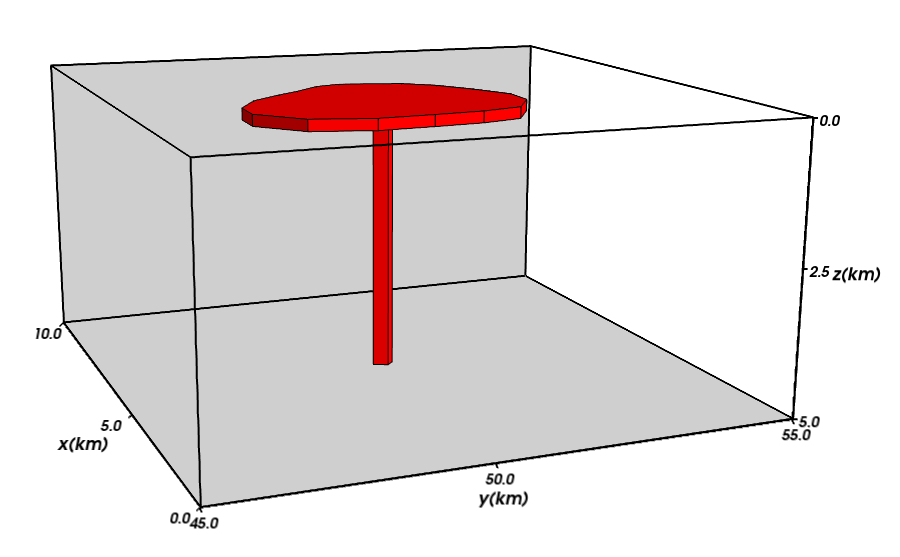

In [8]:
bounds = [0, 10000, 45000, 55000, 0, 5000]
scene = myv.figure(size=(900, 600))
myv.polyprisms(intrusions, color=(1, 0, 0), linewidth=1)
ax = myv.axes(myv.outline(extent=bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.1f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_north(bounds)
myv.wall_bottom(bounds)
scene.scene.camera.position = [-21188.23859879663, 39461.269739903801, -4042.9670131568655]
scene.scene.camera.focal_point = [4463.2000144412032, 50763.844046049599, 3303.2526152180458]
scene.scene.camera.view_angle = 19.2
scene.scene.camera.view_up = [0.23673310150534205, 0.091412372092923133, -0.9672648121791706]
scene.scene.camera.clipping_range = [14711.878768444427, 46945.83259971784]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('intrusion.png')
myv.show()
Image(filename='intrusion.png')

We'll define the basin as a series of right rectangular prisms with top at z = 0. The basin will be semi-infinite along the x axis. Prisms have a width of 500 m along the y direction.

In [9]:
basin_y = np.arange(0, 100000, 500)
basin_depth = np.array(
               [    0.        ,   124.47589099,   243.79258386,   363.10927673,
                  482.4259696 ,   601.74266247,   721.05935535,   840.37604822,
                  959.69274109,  1036.12485823,  1100.04897412,  1163.97309001,
                 1227.8972059 ,  1291.82132179,  1355.74543767,  1419.66955356,
                 1483.59366945,  1547.51778534,  1611.44190123,  1621.98821862,
                 1628.85330853,  1635.71839844,  1642.58348835,  1649.44857826,
                 1656.31366817,  1663.17875808,  1670.04384799,  1676.9089379 ,
                 1683.77402781,  1690.63911773,  1688.42997392,  1676.54164749,
                 1664.65332106,  1652.76499463,  1640.8766682 ,  1628.98834177,
                 1617.10001534,  1605.21168891,  1593.32336248,  1581.43503605,
                 1569.54670962,  1557.65838319,  1545.77005676,  1566.29979036,
                 1680.03144654,  1793.76310273,  1907.49475891,  2021.22641509,
                 2134.95807128,  2248.68972746,  2362.42138365,  2476.15303983,
                 2589.88469602,  2703.6163522 ,  2817.34800839,  2924.39118034,
                 2996.65423431,  3068.91728828,  3141.18034226,  3213.44339623,
                 3285.7064502 ,  3357.96950417,  3430.23255814,  3502.49561211,
                 3574.75866608,  3647.02172005,  3719.28477402,  3791.54782799,
                 3863.81088197,  3930.31483107,  3982.74096826,  4035.16710546,
                 4087.59324265,  4140.01937984,  4192.44551704,  4244.87165423,
                 4297.29779143,  4349.72392862,  4402.15006582,  4454.57620301,
                 4507.00234021,  4559.4284774 ,  4611.8546146 ,  4648.6831761 ,
                 4663.91509434,  4679.14701258,  4694.37893082,  4709.61084906,
                 4724.8427673 ,  4740.07468553,  4755.30660377,  4770.53852201,
                 4785.77044025,  4801.00235849,  4816.23427673,  4831.46619497,
                 4846.69811321,  4849.49504112,  4809.6577165 ,  4769.82039187,
                 4729.98306725,  4690.14574262,  4650.308418  ,  4610.47109337,
                 4570.63376875,  4530.79644412,  4452.95332272,  4367.80139426,
                 4282.64946579,  4197.49753732,  4112.34560885,  4027.19368038,
                 3942.04175191,  3856.88982344,  3771.73789498,  3686.58596651,
                 3601.43403804,  3516.28210957,  3431.1301811 ,  3418.14072327,
                 3492.77712264,  3567.41352201,  3642.04992138,  3716.68632075,
                 3791.32272013,  3865.9591195 ,  3940.59551887,  4015.23191824,
                 4089.86831761,  4164.50471698,  4239.14111635,  4313.77751572,
                 4366.44781574,  4401.02838688,  4435.60895801,  4470.18952915,
                 4504.77010029,  4539.35067143,  4573.93124256,  4608.5118137 ,
                 4643.09238484,  4677.67295597,  4712.25352711,  4746.83409825,
                 4758.52272727,  4755.75328759,  4752.98384791,  4750.21440823,
                 4747.44496855,  4744.67552887,  4741.90608919,  4739.13664951,
                 4736.36720983,  4733.59777015,  4730.82833047,  4728.05889079,
                 4725.28945111,  4722.52001144,  4704.94300314,  4666.86320755,
                 4628.78341195,  4590.70361635,  4552.62382075,  4514.54402516,
                 4476.46422956,  4438.38443396,  4400.30463836,  4362.22484277,
                 4324.14504717,  4286.06525157,  4247.98545597,  4177.60459393,
                 4076.94148209,  3976.27837025,  3875.61525841,  3774.95214657,
                 3674.28903473,  3573.62592289,  3457.06863549,  3192.1657096 ,
                 2927.2627837 ,  2662.35985781,  2405.66037736,  2161.94968553,
                 1918.23899371,  1674.52830189,  1470.0343718 ,  1336.84364487,
                 1203.65291795,  1070.46219102,   937.27146409,   804.08073717,
                  670.89001024,   557.93786926,   473.00838574,   388.07890223,
                  303.14941872,   218.2199352 ,     0.        ,     0.        ,   0.        ])

We'll use the `PrismRelief` of Fatiando to make the basin model. The x dimension of the prisms will be 200 km to make it much larger than the dimensions of the intrusion. The basin has only induced magnetization.

In [10]:
basin_nodes = np.transpose([np.zeros_like(basin_y), basin_y, basin_depth])
basin = mesher.PrismRelief(ref=0, dims=(500, 200000), nodes=basin_nodes)
basin.addprop('magnetization', np.repeat(ang2vec(0.1, inc, dec).reshape((1, 3)), basin.size, axis=0))
# The 0.1 magnetization intensity is a peculiarity of the PrismRelief. We actually want -0.1 but PrismRelief flips the sign
# when the interface is below the reference (in our case, 0 km).

Make a plot of the instrusions and the basin. We'll make it in a 2D view to simplify the plot.

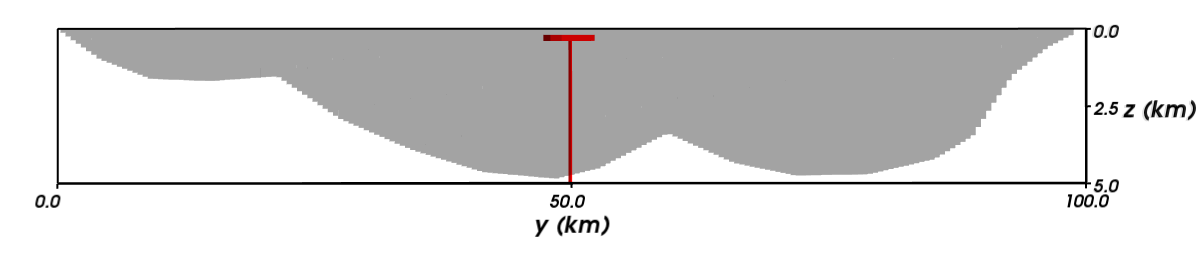

In [55]:
bounds = [0, 10000, 0, 100000, 0, 5000]
scene = myv.figure(size=(1200, 300))
#scene = myv.figure(size=(800, 200))
scale = (1, 1, 3) # Use vertical exaggeration to fit everything into the plot
myv.polyprisms(intrusions, color=(1, 0, 0), edges=False, scale=scale)
myv.prisms(basin, edges=False, color=(0, 0, 0), opacity=0.2, scale=scale)
ax = myv.axes(myv.outline(extent=bounds, scale=scale), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.1f')
#ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.y_label, ax.axes.z_label = 'y (km)', 'z (km)'
ax.axes.y_axis_visibility = False
ax.axes.font_factor = 1.4
scene.scene.parallel_projection = True
scene.scene.camera.position = [-672251.29718383914, 52708.128112285965, 9709.4880680636288]
scene.scene.camera.focal_point = [1.1641532182693481e-09, 52708.128112285965, 9709.4880680636288]
scene.scene.camera.view_angle = 19.2
scene.scene.camera.view_up = [0.0, 0.00039939137299323078, -0.99999992024326245]
scene.scene.camera.clipping_range = [466528.78421200113, 932835.06664159708]
scene.scene.camera.compute_view_plane_normal()
#scene.scene.camera.zoom(7.5*1.25)
scene.scene.camera.zoom(8.97)
scene.scene.render()
myv.savefig('basin_and_instrusion.png')
myv.show()
Image(filename='basin_and_instrusion.png', width=1000)

The grey part are the right rectangular prisms of the basin and the instrusions are in red. The plot has vertical exaggeration.

## Generate noisy synthetic data

Now we can use the model to generate noise-corrupted synthetic total field anomaly (TFA) data. First, we'll specify the area, shape, and height of the data grid. The grid will be located over the sill and pipe at a height of 800 meters.

In [12]:
area = [0, 10000, 45000, 55000]
shape = (100, 100)
z0 = -800
x, y, z = gridder.regular(area, shape, z=z0)

Forward model the synthetic data and contaminate with pseudo-random gaussian noise.

In [13]:
uncertainty_data = 2.0 # nT

In [14]:
tf = contaminate(prism.tf(x, y, z, basin, inc, dec) + polyprism.tf(x, y, z, intrusions, inc, dec),
                  uncertainty_data, seed=0)

c:\Anaconda\lib\site-packages\matplotlib\backends\backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)
c:\Anaconda\lib\site-packages\matplotlib\figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


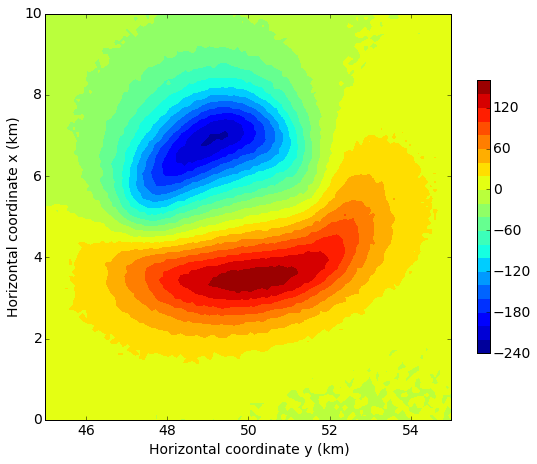

In [15]:
mpl.close('all')
mpl.figure(figsize=(8,8), tight_layout = True)
mpl.axis('scaled')
mpl.contourf(y, x, tf, shape, 20)
mpl.colorbar(shrink = 0.5)
mpl.xlabel('Horizontal coordinate y (km)', fontsize=14)
mpl.ylabel('Horizontal coordinate x (km)', fontsize=14)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.m2km()
mpl.savefig('intrusion-data.pdf', frameon=False, bbox_inches='tight')
mpl.show()

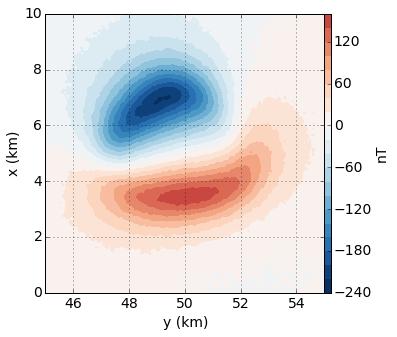

In [16]:
mpl.figure(figsize=(6, 5))
mpl.axis('scaled')
ranges = np.abs([tf.max(), tf.min()]).max()
mpl.contourf(y, x, tf, shape, 20, cmap=mpl.cm.RdBu_r, vmin=-ranges, vmax=ranges)
mpl.colorbar(pad=0, aspect=40).set_label('nT')
mpl.m2km()
mpl.grid()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')

For a better look at the data components, we'll calculate the basin and intrusion fields along a West-East profile at x = 5.5 km and show them separately.

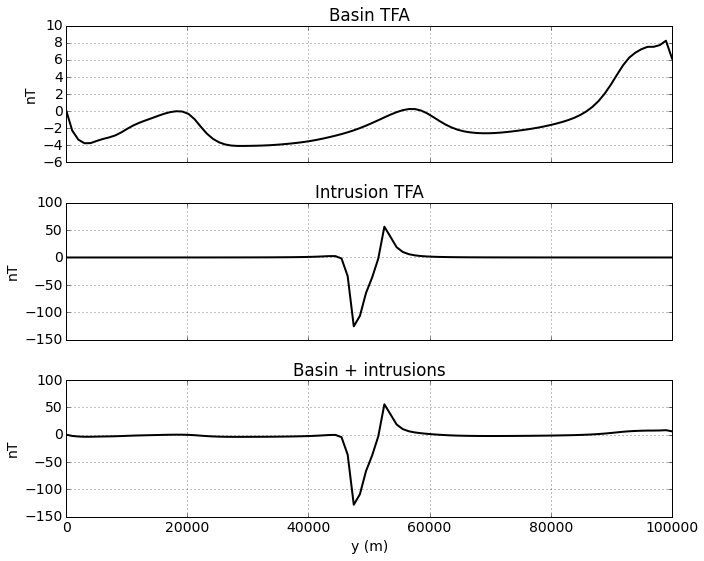

In [17]:
xp = np.linspace(0, 100e3, 100)
yp = np.zeros_like(xp) + 5.5e3
zp = np.zeros_like(xp) + z0
basin_tf = prism.tf(yp, xp, zp, basin, inc, dec)
intrusion_tf = polyprism.tf(yp, xp, zp, intrusions, inc, dec)

fig, axes = mpl.subplots(3, 1, sharex='all', figsize=(10, 8))
ax1, ax2, ax3 = axes
ax1.set_title('Basin TFA')
ax1.plot(xp, basin_tf, '-k', linewidth=2)
ax1.grid()
ax1.set_ylabel('nT')
ax2.set_title('Intrusion TFA')
ax2.plot(xp, intrusion_tf, '-k', linewidth=2)
ax2.grid()
ax2.set_ylabel('nT')
ax3.set_title('Basin + intrusions')
ax3.plot(xp, basin_tf + intrusion_tf, '-k', linewidth=2)
ax3.grid()
ax3.set_ylabel('nT')
ax3.set_xlabel('y (m)')
mpl.tight_layout()

## Estimate the source position with Euler Deconvolution

The position of the intrusion is estimated by using an Euler Deconvolution with the [expanding window strategy](http://fatiando.readthedocs.org/en/v0.3/api/gravmag.euler.html#fatiando.gravmag.euler.ExpandingWindow). 

First, calculate the derivatives using FFT.

In [18]:
dx = fourier.derivx(x, y, tf, shape)
dy = fourier.derivy(x, y, tf, shape)
dz = fourier.derivz(x, y, tf, shape)

**The intrusion and basin model is not an ideal source and does not have a characteristic structural index**. Even so, we'll consider that the synthetic data is produced by a dipole and use a structural index equal to 3.

The center of the expanding window was chosen at the center of the anomaly dipole. We'll run the Euler deconvolution with 20 windows of increasing size. Only one best solution is kept.

In [19]:
euler = Classic(x, y, z, tf, dx, dy, dz, structural_index=3)
solver = ExpandingWindow(euler, center=[5052, 49670], sizes=np.linspace(500, 7000, 20)).fit()
centers = [solver.estimate_]

Plot intrusion (sill and pipe) and the Euler solution.

c:\Anaconda\lib\site-packages\traits\has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


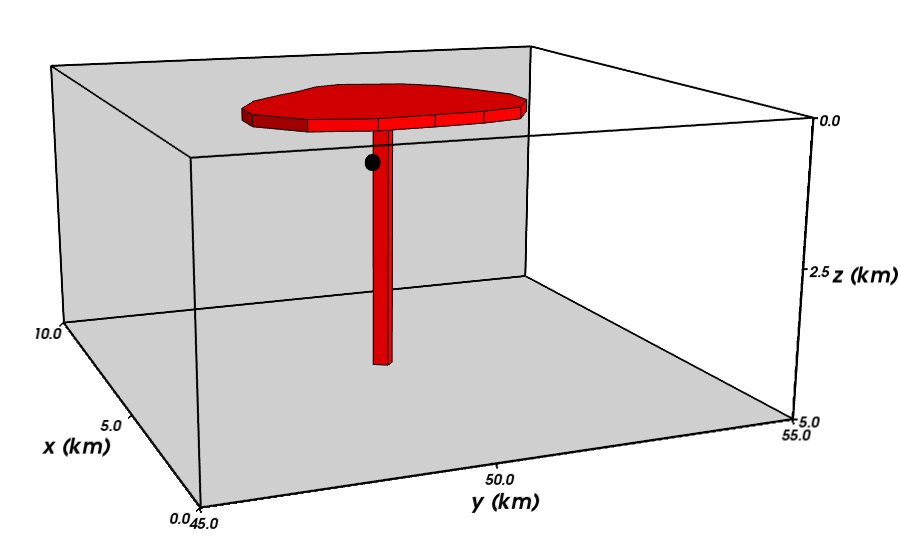

In [20]:
bounds = [0, 10000, 45000, 55000, 0, 5000]
scene = myv.figure(size=(900, 600))
#scene = myv.figure(size=(800, 500))
myv.polyprisms(intrusions, color=(1, 0, 0), linewidth=1)
myv.points(centers, size=150)
ax = myv.axes(myv.outline(extent=bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.1f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.3
myv.wall_north(bounds)
myv.wall_bottom(bounds)
scene.scene.camera.position = [-21188.23859879663, 39461.269739903801, -4042.9670131568655]
scene.scene.camera.focal_point = [4463.2000144412032, 50763.844046049599, 3303.2526152180458]
scene.scene.camera.view_angle = 19.2
scene.scene.camera.view_up = [0.23673310150534205, 0.091412372092923133, -0.9672648121791706]
scene.scene.camera.clipping_range = [14711.878768444427, 46945.83259971784]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('euler_solution.png')
myv.show()
Image(filename='euler_solution.png')

The intrusion is shown in red and the Euler solution as a black sphere. **Notice that the Euler solution falls outside the intrusion**.

## Estimate the magnetization direction

We'll use the proposed method to estimate the magnetization direction using the Euler solution obtained above.

In [21]:
#L2-norm estimate
solver_L2 = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit()
for i in range(100):
    w = np.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

In [22]:
print('Inclination    |  Declination')
print('True')
print('%12.5f   | %12.5f' % (inc_intrusion, dec_intrusion))
print('Estimated L2')
print('%12.5f   | %12.5f' % (solver_L2.estimate_[0][1], solver_L2.estimate_[0][2]))
print('Uncertainties L2')
print('%12.5f   | %12.5f' % (dh_L2[0][1], dh_L2[0][2]))
print('Estimated L1')
print('%12.5f   | %12.5f' % (solver_L1.estimate_[0][1], solver_L1.estimate_[0][2]))
print('Uncertainties L1')
print('%12.5f   | %12.5f' % (dh_L1[0][1], dh_L1[0][2]))

Inclination    |  Declination
True
    39.80000   |    157.50000
Estimated L2
    37.33816   |    167.39501
Uncertainties L2
     0.00035   |      0.00060
Estimated L1
    39.99470   |    164.19461
Uncertainties L1
     0.00939   |      0.02669


Plot the results on a stereonet.

(0.0, 1.0)

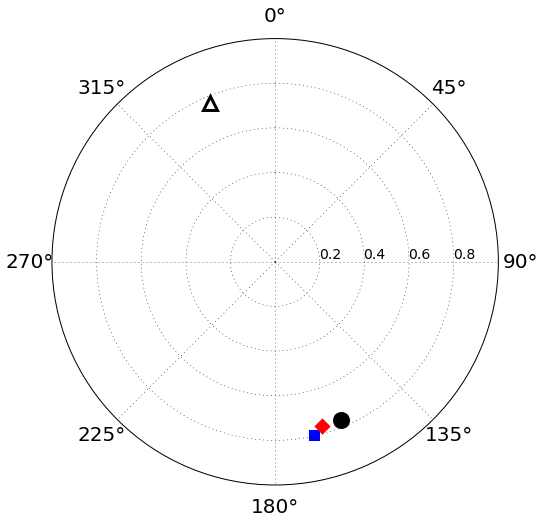

In [23]:
hg = np.sqrt((np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec)))**2 + 
             (np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec)))**2)
ht = np.sqrt((np.cos(np.deg2rad(inc_intrusion))*np.cos(np.deg2rad(dec_intrusion)))**2 + 
             (np.cos(np.deg2rad(inc_intrusion))*np.sin(np.deg2rad(dec_intrusion)))**2)

mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rgrids([0.2,0.4,0.6,0.8], angle=90.)
# direction of the Geomagnetic field
if inc >= 0.0:
    mpl.plot(np.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(np.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, fillstyle='none')
# true magnetization direction
if inc_intrusion >= 0.0:
    mpl.plot(np.deg2rad(dec_intrusion), ht, marker='o', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(np.deg2rad(dec_intrusion), ht, marker='o', ms=14, 
             mec='k', mew=3, fillstyle='none')
# L2-norm estimates
for e in solver_L2.estimate_:
    he = np.sqrt((np.cos(np.deg2rad(e[1]))*np.cos(np.deg2rad(e[2])))**2 + \
                 (np.cos(np.deg2rad(e[1]))*np.sin(np.deg2rad(e[2])))**2)
    if e[1] >= 0.0:
        mpl.plot(np.deg2rad(e[2]), he, marker='s', ms=8, 
             mec='b', mew=3, mfc='b', fillstyle='full')
    else:
        mpl.plot(np.deg2rad(e[2]), he, marker='s', ms=8, 
             mec='b', mew=3, fillstyle='none')
# L1-norm estimates
for e in solver_L1.estimate_:
    he = np.sqrt((np.cos(np.deg2rad(e[1]))*np.cos(np.deg2rad(e[2])))**2 + \
                 (np.cos(np.deg2rad(e[1]))*np.sin(np.deg2rad(e[2])))**2)
    if e[1] >= 0.0:
        mpl.plot(np.deg2rad(e[2]), he, marker='D', ms=8, 
             mec='r', mew=3, mfc='r', fillstyle='full')
    else:
        mpl.plot(np.deg2rad(e[2]), he, marker='D', ms=8, 
             mec='r', mew=3, fillstyle='none')#c.set_alpha(1.0)
mpl.xticks(fontsize=20) # on the cicle
mpl.yticks(fontsize=14) # along the radial direction
mpl.ylim(0.0, 1.0)

This figure is a stereographical projection of the directions of the geomagnetic field (open triangle), true magnetization of the synthetic intrusion (solid-black circle), least-squares estimate (solid-blue square) and robust estimate (solid-red diamond). Open symbols indicate upper hemisphere and solid symbols indicate lower hemisphere.

Plot the data fit obtained via the least-squares and robust approaches.

c:\Anaconda\lib\site-packages\matplotlib\contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)
c:\Anaconda\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
c:\Anaconda\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


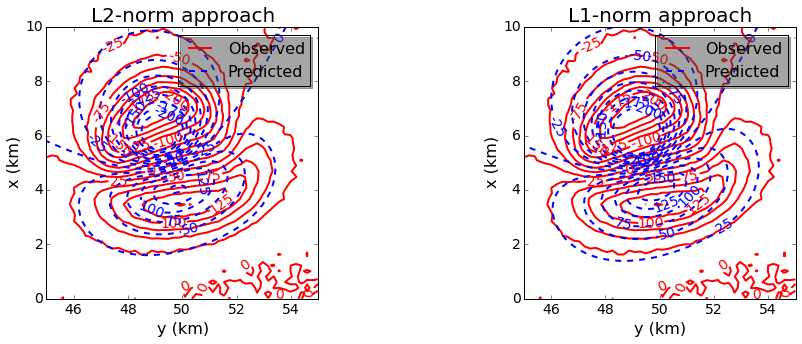

In [24]:
mpl.figure(figsize=(14, 5), tight_layout = True)
mpl.subplot(1, 2, 1)
mpl.title("L2-norm approach", fontsize = 20)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='best', shadow=True, prop={'size':16})
mpl.xlabel('y (km)', fontsize = 16)
mpl.ylabel('x (km)', fontsize = 16)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title("L1-norm approach", fontsize = 20)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='best', shadow=True, prop={'size':16})
mpl.xlabel('y (km)', fontsize = 16)
mpl.ylabel('x (km)', fontsize = 16)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.m2km()

## Test the estimated direction by reduction to the pole

The quality of the estimated magnetization direction can be accessed by performing a reduction to the pole (RTP). If the estimated magnetization direction is close to the true one, the RTP produces a magnetic anomaly predominantly positive over the magnetic source. In this numerical test, we analyze the estimated magnetization direction obtained by the robust (L1-norm) approach. This is done by performing a RTP via the [Polynomial Equivalent Layer](http://dx.doi.org/10.1190/geo2012-0196.1) (PEL) technique.

Setup a point layer and estimate the magnetization intensity using the PEL. The layer is located 300 meters below the data grid.

In [25]:
layer = mesher.PointGrid(area, z0 + 300.0, shape)
# Setup the solver for the PEL with 20x20 windows and polynomials of degree 1
windows = (20, 20)
degree = 1
misfit = PELTotalField(x, y, z, tf, inc, dec, layer, windows, degree, 
                       sinc=solver_L1.estimate_[0][1], sdec=solver_L1.estimate_[0][2])
# Use smoothness regularization between each window
regul = PELSmoothness(layer, windows, degree)

The regularization parameter is determined through an L-curve analysis. The `LCurve` object of Fatiando a Terra runs the many inversions and automatically selects the "elbow" point. All of this is done when `fit()` is called.

In [26]:
eql_solver = LCurve(misfit, regul, [10**i for i in range(-20, -10)]).fit()
# Add the estimated magnetization to the layer
layer.addprop('magnetization', eql_solver.estimate_)

Plot the L-curve for the PEL regularization parameter.

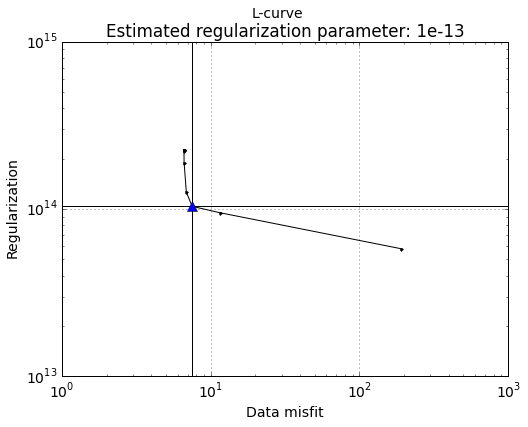

In [27]:
mpl.figure(figsize=(8, 6))
mpl.suptitle('L-curve', fontsize=14)
mpl.title("Estimated regularization parameter: %g" % (eql_solver.regul_param_))
eql_solver.plot_lcurve()
mpl.grid()
mpl.xlabel('Data misfit')
mpl.ylabel('Regularization')

Plot the data fit of the PEL.

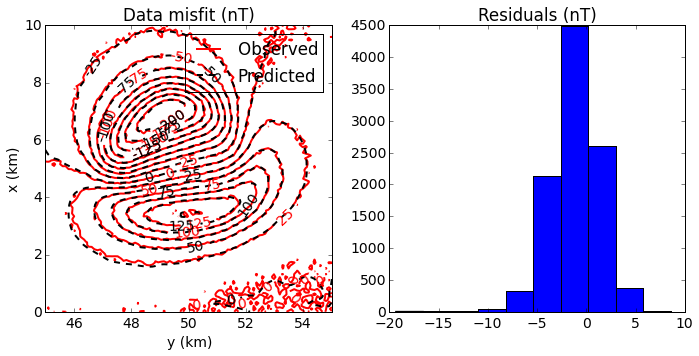

In [28]:
mpl.figure(figsize=(10, 5),  tight_layout=True)
mpl.subplot(1, 2, 1)
mpl.axis('scaled')
mpl.title('Data misfit (nT)')
levels = mpl.contour(y, x, tf, shape, 15, color='r', label='Observed', 
                     linewidth=2.0)
mpl.contour(y, x, eql_solver.predicted(), shape, levels, color='k',
            style='dashed', label='Predicted', linewidth=2.0)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.legend(loc='best')
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.hist(eql_solver.residuals(), bins=10)
mpl.title('Residuals (nT)')

New we can use the equivalent layer to calculate the total field anomaly at the pole.

In [29]:
reduced = sphere.tf(x, y, z, layer, -90, 0)

Compute the actual anomaly at the pole produced by the basin and intrusion model.

In [30]:
vert_mag = ang2vec(1, -90, 0) # versor for vertical magnetization
tfpole = polyprism.tf(x, y, z, intrusions, -90, 0, pmag=6*vert_mag) + prism.tf(x, y, z, basin, -90, 0, pmag=-0.1*vert_mag)

Plot the reduced-to-the-pole anomaly and the true anomaly calculated at the pole.

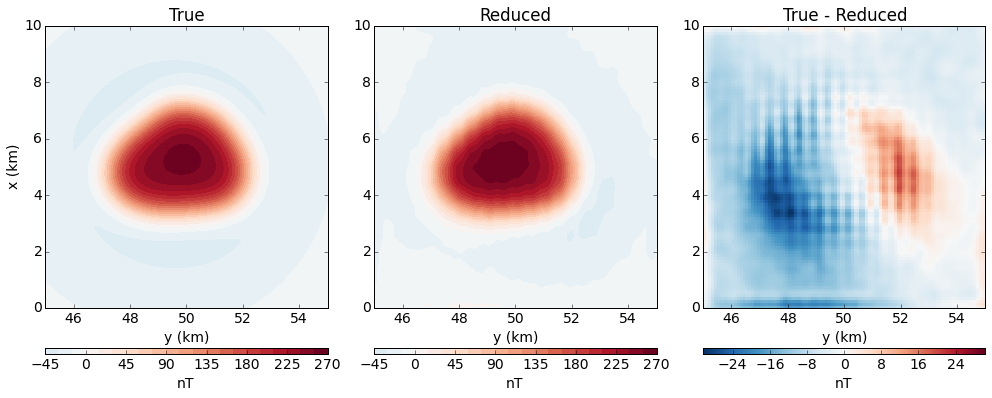

In [31]:
ranges = np.abs([reduced.min(), reduced.max()]).max()
args = dict(shape=shape, levels=20, cmap=mpl.cm.RdBu_r, vmin=-ranges, vmax=ranges)
cbargs = dict(orientation='horizontal', aspect=50, pad=0.1)
fig, axes = mpl.subplots(1, 3, figsize=(14, 6))
ax1, ax2, ax3 = axes
for ax in axes:
    ax.set_aspect('equal')
mpl.sca(ax1)
mpl.title('True')
mpl.contourf(y, x, tfpole, **args)
mpl.colorbar(**cbargs).set_label('nT')
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.sca(ax2)
mpl.title('Reduced')
mpl.contourf(y, x, reduced, **args)
mpl.colorbar(**cbargs).set_label('nT')
mpl.xlabel('y (km)')
mpl.m2km()
mpl.sca(ax3)
diff = tfpole - reduced
dranges = np.abs([diff.min(), diff.max()]).max()
mpl.title('True - Reduced')
mpl.pcolor(y, x, diff, shape, cmap=mpl.cm.RdBu_r, vmin=-dranges, vmax=dranges)
mpl.colorbar(**cbargs).set_label('nT')
mpl.xlabel('y (km)')
mpl.m2km()
mpl.tight_layout()

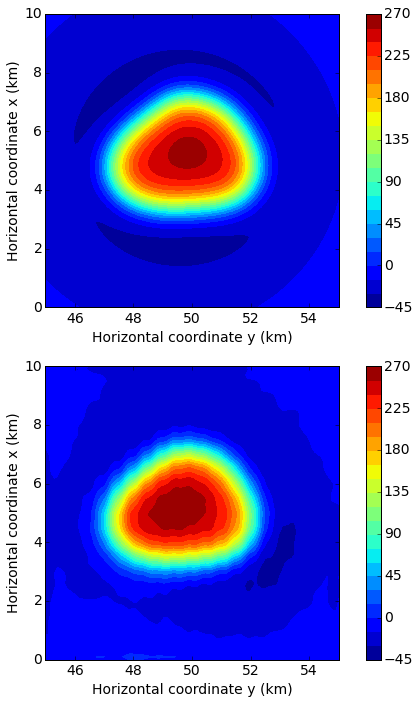

In [32]:
# Plot the reduced data

mpl.close('all')
mpl.figure(figsize=(8, 10), tight_layout = True)

mpl.subplot(2, 1, 1)
mpl.axis('scaled')
mpl.contourf(y, x, tfpole, shape, 20, interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()

mpl.subplot(2, 1, 2)
mpl.axis('scaled')
mpl.contourf(y, x, reduced, shape, 20, interp=True, extrapolate=True)
mpl.colorbar()
mpl.ylabel('Horizontal coordinate x (km)', fontsize = 14)
mpl.xlabel('Horizontal coordinate y (km)', fontsize = 14)
mpl.m2km()

mpl.savefig('intrusion_RTP.pdf', frameon=False, bbox_inches='tight')

mpl.show()